In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pointCollection as pc
import os
import h5py
%matplotlib widget

# make a set of simulated groundtracks 

We'll do this the quick and sloppy way by replicating rgt 001 with shifts in the longitude direction

In [2]:

def calc_xatc(rgt1):
    
    dLat = np.diff(rgt1.latitude)
    dLon = np.diff(np.unwrap(rgt1.longitude, period=360))
    
    Re = 6378137.0
    #flattening
    f = 1/298.25722356
    
    #radius in km
    r = Re * (1-f*np.sin(rgt1.latitude*np.pi/180)**2) 
    scale = (np.cos(rgt1.latitude[1:]*np.pi/180) + np.cos(rgt1.latitude[0:-1]*np.pi/180))*0.5
    dS = (r[0:-1]+r[1:])/2* np.pi/180* np.sqrt(dLat**2 + (dLon*scale)**2)
    dist = np.append(0, np.cumsum(dS))
    return dist

def shift_atc(D, dxy, ind=None, inplace=True, assign_vectors=True, return_new=False):
    '''
    Shift a track by dxy in along-track coordinates
    '''

    if ind is None:
        ind=np.arange(D.size, dtype=int)

    if 'v_atc_x' not in D.fields:
        s_hat = np.diff(D.x+1j*D.y)
        s_hat /= np.abs(s_hat)
        s_hat=np.append(s_hat, s_hat[-1])
        if assign_vectors:
            D.assign(v_atc_x = np.real(s_hat))
            D.assign(v_atc_y = np.imag(s_hat))
    else:
        s_hat = D.v_atc_x +1j*D.v_atc_y
    delta = s_hat[ind] * dxy[0] + 1j*s_hat[ind]*dxy[1]
    
    if inplace:
        D.x[ind] += np.real(delta)
        D.y[ind] += np.imag(delta)
        return
        
    x1 = D.x 
    y1 = D.y 
    x1[ind] += np.real(delta)
    y1[ind] += np.imag(delta)
    
    if return_new:
        return pc.data().from_dict({'x':x1,'y':y1})
    else:
        return x1, y1

def to_xy(latitude, longitude, lat_0, lon_0):
    lat_scale=(6378e3*2*np.pi/360.)
    lon_scale=(6378e3*2*np.pi/360.*np.cos(lat_0*np.pi/180))
    x=(longitude-lon_0)*lon_scale
    y=(latitude-lat_0)*lat_scale
    return x, y

def to_latlon(x, y, lat_0, lon_0):
    lat_scale=(6378e3*2*np.pi/360.)
    lon_scale=(6378e3*2*np.pi/360.*np.cos(lat_0*np.pi/180))
    longitude = lon_0 + (x/lon_scale)
    latitude = lat_0 + (y/lat_scale)
    return latitude, longitude

def calc_azimuth(D, lat0, lon0):
    x1, y1 = to_xy(D.latitude+0.001, D.longitude, lat0, lon0)
    n_hat = (x1+1j*y1) - (D.x+1j*D.y)
    n_hat /= np.abs(n_hat)
    track_hat = D.v_atc_x + 1j*D.v_atc_y
    D.assign(seg_azimuth = np.angle(track_hat * np.conj(n_hat)))
    
def make_sim_tracks( cycles=np.arange(1, 11), W_data = 5.e4, 
                    rgt_file='rgt_001.h5', lat_0=70, lon_0=0, product='ATL11'):

    if product=='ATL11':
        along_track_spacing=60
    else:
        along_track_spacing=20
    
    rgt1 = pc.data().from_h5(rgt_file, group='/')
    with h5py.File(rgt_file,'r') as h5f:
        t_orbit = h5f.attrs['t_orbit']
        # correction value
        delta_lon_orbit=h5f.attrs['delta_lon_orbit'] +-0.00096
    rgt1.assign(x_atc=calc_xatc(rgt1))
    
    lat_tol = np.maximum(W_data, 7000)/(6378e3*2*np.pi/360.)
    lon_tol = np.maximum(W_data+3000, 10000)/(6378e3*2*np.pi/360.*np.cos(lat_0*np.pi/180))
    
    # pick the parts of the orbit that are ascending and descending
    desc = (rgt1.t > t_orbit/4) & (rgt1.t < 3*t_orbit/4)
    asc = desc==0
    rgt_desc = rgt1[desc & (np.abs(rgt1.latitude - lat_0) < lat_tol)]
    rgt_asc = rgt1[asc & (np.abs(rgt1.latitude - lat_0) < lat_tol)]
    
    orbs={key:[] for key in ['asc','desc']}
    
    # replicate the rgt for each orbit in a cycle, keep data close to the reference point
    for track in range(1387):
        for key, rgt in zip(['asc','desc'], [rgt_asc, rgt_desc]):
            temp=rgt.copy()
            temp.t += t_orbit*track
            temp.longitude += delta_lon_orbit * track
            delta_lon = np.mod(temp.longitude-lon_0+180, 360)-180
            if np.any(np.abs(delta_lon) < lon_tol):
                temp.longitude = np.mod(temp.longitude+180, 360)-180
                temp.assign(rgt=np.zeros_like(temp.t)+track)
                orbs[key] += [temp]

    rgts=[]
    for orb in orbs['asc']+orbs['desc']:       
        x, y = to_xy(orb.latitude, orb.longitude, lat_0, lon_0)
        
        segment_ids_float = orb.x_atc/along_track_spacing
        segment_ids = np.arange(np.ceil(segment_ids_float[0]), np.floor(segment_ids_float[-1]))
        rgt=pc.data().from_dict({field:np.interp(segment_ids, segment_ids_float, var) 
                                 for field, var in zip(['x','y','t','rgt', 'x_atc', 'longitude','latitude'], 
                                                       [x, y, orb.t, orb.rgt, orb.x_atc, orb.longitude, orb.latitude])})
        rgt.assign(y_atc=np.zeros_like(rgt.x))
        rgt.assign(segment_id = segment_ids * int(along_track_spacing/20))
        # shift by zero so that the along-track vectors are defined.
        shift_atc(rgt, [0, 0])
        calc_azimuth(rgt, lat_0, lon_0)
        rgts += [rgt]
    # shift the rgts to make the beam pairs
    D_GTs=[]
    for rgt in rgts:
        for pair, dy in zip([1, 2, 3], [-3.3e3, 0, 3.3e3]):
            D_GT=rgt.copy()
            #print([rgt.rgt[0], pair, 'before', np.min(D_GT.x), np.max(D_GT.x)])
            shift_atc(D_GT, [0, dy])
            D_GT.y_atc += dy
            #print([rgt.rgt[0], pair, 'after', np.min(D_GT.x), np.max(D_GT.x)]) 
            D_GT.assign(pair=pair+np.zeros_like(D_GT.t))
            if product=='ATL11':
                D_GTs += [D_GT]
            else:
                # if we're making ATL06, shift the pairs to make the beams
                for beam, dyb in zip([0, 1], [-45, 45]):
                    D_beam = D_GT.copy()
                    shift_atc(D_beam, [0, dyb])
                    D_beam.y_atc += dyb
                    D_beam.assign(beam = beam+np.zeros_like(D_beam.t))
                    
                    D_GTs += [D_beam]
            #print()
    D_cycle1=pc.data().from_list(D_GTs)
    
    D_cycle1.index(np.all(np.abs(np.c_[D_cycle1.x, D_cycle1.y]) < W_data/2, axis=1))

    # replicate cycle1 to make a full set of cycles
    D=[]
    for cycle in cycles:
        D_cycle=D_cycle1.copy()
        D_cycle.t += 91*cycle
        D_cycle.assign(cycle=np.zeros_like(D_cycle.t)+cycle)
        D += [D_cycle]
    D=pc.data().from_list(D)
    return D


def apply_shifts(D, vars, sigma, dims=['y'], shifts=None, shift_dict=None, update_yatc=False):
    '''
    Shift the tracks in D in along-track coordinates.
    '''
    if shift_dict is not None:
        shift_keys=list_shift_dict.keys()
    else:
        shift_keys, shift_dict = pc.unique_by_rows(np.c_[[getattr(D, var) for var in vars]].T, return_dict=True)
    if shifts is None:
        shifts = np.zeros([len(shift_keys), 2])
        for dim in dims:
            shifts[:, ['x','y'].index(dim)] = np.random.randn(len(shift_keys))*sigma
    
    for (this_key, ii), this_shift in zip(shift_dict.items(), shifts):
        shift_atc(D, this_shift, ind=ii)
        if update_yatc:
            D.y_atc[ii] += this_shift[1]
    return shift_dict, shifts


In [3]:
cycle_range=[1, 16]
lat_0=70
lon_0=0
sigma_rgt = 10

D_prototype=make_sim_tracks(cycles=np.arange(*cycle_range), lat_0=lat_0, product='ATL06')
D_noE = D_prototype.copy()
cr_dict, cr_shift = apply_shifts(D_noE, ['cycle','rgt'], sigma_rgt, update_yatc=True)

D_noE.latitude, D_noE.longitude = to_latlon(D_noE.x, D_noE.y, lat_0, lon_0)


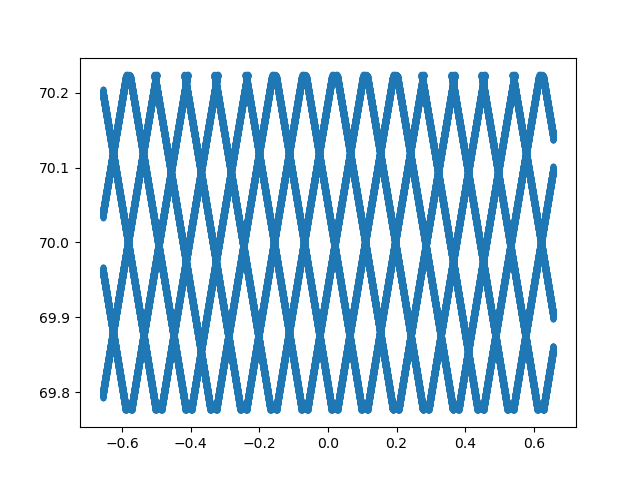

In [4]:
jj = D_noE.cycle < 2
plt.figure()
plt.plot(D_noE.longitude[jj], D_noE.latitude[jj],'.')

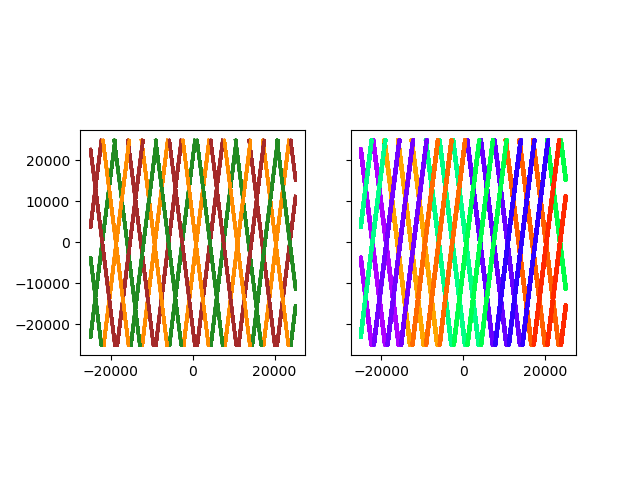

In [5]:
# plot the simulated data, colored by pair number
_, d_plt = pc.unique_by_rows(np.c_[D_noE.cycle, D_noE.rgt, D_noE.pair, D_noE.beam], return_dict=True)
hf, hax=plt.subplots(1, 2, sharex=True, sharey=True)

plt.sca(hax[0])
colors={1:'darkorange', 2:'brown',3:'forestgreen'}

for key, ii in d_plt.items():
    ii = ii[np.argsort(D_noE.t[ii])]
    plt.plot(D_noE.x[ii], D_noE.y[ii],marker='.', markersize=2, color=colors[key[2]])
plt.gca().set_aspect(1)

plt.sca(hax[1])

plt.scatter(D_noE.x, D_noE.y, 2, c=np.mod(D_noE.t, 91), clim=[0, 91], cmap='hsv')
plt.gca().set_aspect(1)


In [6]:
# define the z function and errors
sigma_z_corr = 0.03
sigma_z_uncorr = 0.16/np.sqrt(57)
mean_slope=0.1
sigma_geoloc = 3.5


In [7]:

# define a function to set the z values for the data:
def z_plane(D, mean_slope=0.1, xy0=[0,0] ):
    return (D.x-xy0[0])*mean_slope
z_fn = z_plane
z_args = {'mean_slope':0.1, 'xy0':[0, 0]}

In [12]:
# apply errors
# the geolocation error is created by shifting the true geolocations by sigma_geoloc,
# and calculating the z function based on the shifted locations
# the data geolocations do not have the sigma_geoloc shift, so they contain the effective
# geolocation error

# calculate the along-track slope:
z_temp=[None, None]
for jj, dx in enumerate([-10, 10]):
    temp=D_noE.copy()
    shift_atc(temp, [dx, 0], inplace=True)
    z_temp[jj] = z_fn(temp, **z_args)
D_noE.assign(dh_fit_dx = (z_temp[1]-z_temp[0])/20)
D_noE.assign(dh_fit_dx_sigma = 0.16 / np.sqrt(57/2) /20. + np.zeros_like(D_noE.x))

data=D_noE.copy()

cr_dict, cr_geoloc = apply_shifts(D_noE, ['cycle','rgt'], sigma_geoloc)

data.assign(z=z_fn(D_noE, **z_args))
data.assign(dem_h=z_fn(data, **z_args))

# assign random and correlated errors
e_corr = np.random.randn(len(cr_dict)) * sigma_z_corr
for ii, ee in zip(cr_dict.values(), e_corr):
    data.z[ii] += ee
data.z += np.random.randn(data.size)* sigma_z_uncorr

# convert data.t to years
data.t /= 365.25

data.latitude, data.longitude = to_latlon(data.x, data.y, lat_0, lon_0)


In [13]:
print(data.summary())

field 	shape 	n_finite 	STD 	 minmax
x	(2302905,)	2302905	1.45e+04	-2.50e+04 2.50e+04
y	(2302905,)	2302905	1.44e+04	-2.50e+04 2.50e+04
t	(2302905,)	2302905	1.08e+00	2.56e-01 3.93e+00
rgt	(2302905,)	2302905	4.01e+02	3.80e+01 1.10e+03
x_atc	(2302905,)	2302905	2.21e+06	7.80e+06 1.23e+07
longitude	(2302905,)	2302905	3.80e-01	-6.57e-01 6.57e-01
latitude	(2302905,)	2302905	1.30e-01	6.98e+01 7.02e+01
y_atc	(2302905,)	2302905	2.69e+03	-3.37e+03 3.38e+03
segment_id	(2302905,)	2302905	1.11e+05	3.90e+05 6.14e+05
v_atc_x	(2302905,)	2302905	1.26e-03	-1.26e-01 -1.21e-01
v_atc_y	(2302905,)	2302905	9.92e-01	-9.93e-01 9.93e-01
seg_azimuth	(2302905,)	2302905	1.45e+00	1.22e-01 3.02e+00
pair	(2302905,)	2302905	8.15e-01	1.00e+00 3.00e+00
beam	(2302905,)	2302905	5.00e-01	0.00e+00 1.00e+00
cycle	(2302905,)	2302905	4.32e+00	1.00e+00 1.50e+01
dh_fit_dx	(2302905,)	2302905	1.26e-04	-1.26e-02 -1.21e-02
dh_fit_dx_sigma	(2302905,)	2302905	7.59e-18	1.50e-03 1.50e-03
z	(2302905,)	2302905	1.45e+03	-2.50e+03 2.50e+03
d

In [14]:
data.to_h5('/Users/ben/temp/sim_ALT06_data_with_errors.h5')

In [11]:
import ATL11

# run LSsurf.smooth_fit to make a gridded elevation model


In [ ]:

from LSsurf.smooth_fit import smooth_fit
E_d3zdx2dt=0.0001
E_d2z0dx2=0.06
E_d2zdt2=5000



bias_params=None
data.assign({'sigma':np.zeros_like(data.z)+0.1})

data_nobias=data.copy()

ctr={'x':0,'y':0,'t':np.mean(cycle_range)*0.25}
W={'x':2.e4,'y':2.e4,'t':np.diff(cycle_range)*0.25}
spacing={'z0':100, 'dz':500, 'dt':0.25}

data_gap_scale=2500
E_RMS={'d2z0_dx2':E_d2z0dx2, 'dz0_dx':E_d2z0dx2*data_gap_scale, 'd3z_dx2dt':E_d3zdx2dt, 'd2z_dxdt':E_d3zdx2dt*data_gap_scale,  'd2z_dt2':E_d2zdt2}

# run the fit with no bias params
S_nobias=smooth_fit(data=data_nobias, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
             reference_epoch=5, compute_E=False,
             max_iterations=1,
             bias_params=None,
             VERBOSE=True, dzdt_lags=[1])

bias_params=['cycle','rgt']
data.assign({'sigma_corr':np.zeros_like(data.z)+((mean_slope*sigma_geoloc)**2+0.03**2)**0.5})

# run the fit with bias params
S_bias=smooth_fit(data=data, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
             reference_epoch=5, compute_E=False,
             max_iterations=1,
             bias_params=bias_params,
             VERBOSE=True, dzdt_lags=[1])


In [ ]:
hf, hax=plt.subplots(2, 2, layout='constrained', sharex=True)
for z0, ax in zip([S_nobias['m']['z0'], S_bias['m']['z0']], hax):
    z0.show(field='z0', gradient=True, clim=[-0.1, 0.1], ax=ax[0])
    ax[1].plot(z0.x, z0.z0[np.argmin(np.abs(z0.y-0)),:] - mean_slope*z0.x)
hax[1,1].set_ylim(hax[0, 1].get_ylim())

#plt.colorbar(z0.show(field='z0', cmap='RdBu'), alpha=0.3)

In [ ]:
hax[1,1].set_ylim(hax[0, 1].get_ylim())


In [ ]:
plt.figure()
plt.colorbar(
    plt.imshow(np.std(dz.dz, axis=2)))

In [ ]:
row=np.argmin(np.abs(z0.y-2500))
plt.figure()
plt.plot(z0.x, z0.z0[row,:])
plt.plot(z0.y, z0.z0[:,0])

In [ ]:
import LSsurf as LS

In [ ]:
fdg=LS.fd_grid(bounds=[[-1, 1], [-10, 10]], deltas=[2, 1])

In [ ]:
fdg.ctrs[1]

Linear interpolation:

$ \textbf{W} = [(x1 - x)/dx, (x-x0)/dx] $

$\delta_z = [z_{m0}, z_{m}] \cdot \textbf{W} $

Linear extrapolation:

$ \textbf{W} = [x-x0] $

$ \delta_z = [dz/dx] \cdot W $